# Project Human Language Technology - OffensEval2019
# Task 1
## BERT Small
This notebook will explore a model for competition "OffensEval 2019: Identifying and Categorizing Offensive Language in Social Media" using BERT Small. \\
BERT Small a pre-trained model with structure is __L = 4 and H = 512__ \\
Matricola: 505252 Michele Morisco

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp drive/MyDrive/Library/PreProcessing.py .
!cp drive/MyDrive/Library/BERTBase.py .
!cp drive/MyDrive/Library/AnalysisGraph.py .

In [ ]:
#!pip install pytorch-pretrained-bert pytorch-nlp
!pip install emoji --upgrade
!pip install wordsegment
!pip install transformers 
!pip install ekphrasis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 32.2 MB/s 
  Created wheel for emoji: filename=emoji-2.1.0-py3-none-any.whl size=212392 sha256=0b87a5c349fce708000229d56bd3a47d1f9903325fbcef48de79d3173cbc14ba
  Stored in directory: /root/.cache/pip/wheels/77/75/99/51c2a119f4cfd3af7b49cc57e4f737bed7e40b348a85d82804
Successfully built emoji
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.8 MB 30.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 30.3 MB/s 
     |████████████████████████████████| 7.6 MB 65.5 MB/s 
     |████████████████████████████████| 163 kB 75.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |███████████████████████████

In [ ]:
from PreProcessing import load_dataset
from BERTBase import run_with_kfold, evaluateFinal
from AnalysisGraph import show_confusion_matrix, show_report, showWrongPredictions

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
import string
string.punctuation
import csv
import pandas as pd
import numpy as np

from transformers import BertForSequenceClassification, BertConfig, BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score
import torch
from torch import tensor
import torch.nn as nn
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import random

#% matplotlib inline

#Random seed initialization for replicability of results
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

import warnings
warnings.filterwarnings("ignore")

In [ ]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))
    !nvidia-smi
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4
Thu Oct 13 09:29:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                    

In [ ]:
#SET THE PARAMETERS FOR TRAINING 
H_PARAMETERS = {'model_name': 'prajjwal1/bert-small', 'unit_layers' : [512, 64, 32, 2], 'dropout' : 0.5, 'folds' : 4, 'batch_size': 32, 
                'warmup_proportion' : 0.1, 'learning_rate': 2e-4, 'loss' : nn.CrossEntropyLoss(), 'num_epochs': 3, 'device' : device}

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
#dataset = open("OLID/olid-training-v1.0.tsv")
data, label = load_dataset(dataset_path = 'drive/MyDrive/HLT/OLID/')

#0 = NOT, 1 = OFF
data.subtask_a.value_counts()

Word statistics files not found!
Downloading... done!
Unpacking... done!
Reading english - 1grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/english/counts_1grams.txt
Reading english - 2grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/english/counts_2grams.txt
Reading english - 1grams ...
user canada need another cuck already enough looney leave liberals fking great country qp roof trudeau must go


NOT    8840
OFF    4400
Name: subtask_a, dtype: int64

In [ ]:
data.tweet.sample(20)

12823                     user good antifa violent fascism
12290    user de create slowly stealthily since conserv...
8474     christian kabasele reveal secrets behind watfo...
4676     user oppose neutral jurist sit scotus weigh me...
397      user wonder apologize diamond silk call minstr...
10957    user know canada want seem enough problems lib...
3311                                        user love maga
12936    user agree still conservatives heart may hate ...
8575                         play water slider summer http
4392     kyky u love u anfield putain la cliiimmmm liv psg
7673     user compromise active investigation sound lik...
12966    fill sky chemicals frequencies ido consent con...
12215    love one another starlight darkness surround m...
5480     verge collapse break wave cannot explain whole...
3535                user hair polyester fibers yoda puppet
4425                           user first regression laugh
5523     user well brandon conservatives get elect red .

In [ ]:
X_train = list(data.tweet.values)

In [ ]:
MAX_SEQ_LENGTH = 64

tokenizer = BertTokenizer.from_pretrained(H_PARAMETERS['model_name'], do_lower_case=True)
sentences = data.tweet.values
tokens = tokenizer(X_train, padding=True, truncation=True, max_length=MAX_SEQ_LENGTH)

# Create input ids
input_ids = []
# Create attention masks
attention_masks = []

input_ids_train = torch.tensor(tokens['input_ids'])
attention_masks_train  = torch.tensor(tokens['attention_mask'])

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/286 [00:00<?, ?B/s]

In [ ]:
print('Original: ', sentences[0])
print('Token IDs:', input_ids_train[0])

Original:  user ask native americans take
Token IDs: tensor([ 101, 5310, 3198, 3128, 4841, 2202,  102,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])


In [ ]:
loss_fn = nn.CrossEntropyLoss()

In [ ]:
test_data, label_test = load_dataset(dataset_path = 'drive/MyDrive/HLT/OLID/', dataset='testset-levela.tsv', dataset_label='labels-levela.csv')
X_test = list(test_data.tweet.values)

Reading english - 1grams ...
Reading english - 2grams ...
Reading english - 1grams ...
bigg boss tamil janani task go first final listclapping hand clap hand clap hand clap hand


In [ ]:
tokens = tokenizer(X_test, padding=True, truncation=True, max_length=MAX_SEQ_LENGTH)

# Create input ids
input_ids = []
# Create attention masks
attention_masks = []

input_ids_test = torch.tensor(tokens['input_ids'])
attention_masks_test  = torch.tensor(tokens['attention_mask'])

test_dataset = TensorDataset(input_ids_test, attention_masks_test, torch.tensor(label_test))
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=len(test_dataset))

Downloading:   0%|          | 0.00/116M [00:00<?, ?B/s]

Some weights of the model checkpoint at prajjwal1/bert-small were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sequential(
  (0): Linear(in_features=512, out_features=64, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=64, out_features=32, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=32, out_features=2, bias=True)
)
Start training...

 Epoch  |  Batch  |  Train Loss  | F1 Train  |  Val Loss  |  Val Acc  |  F1 Val   |  Elapsed 
-----------------------------------------------------------------------------------------------
   1    |   20    |   0.676254   |   0.46    |     -      |     -     |     -     |   3.75   
   1    |   40    |   0.653028   |   0.45    |     -      |     -     |     -     |   1.11   
   1    |   60    |   0.621690   |   0.56    |     -      |     -     |     -     |   1.11   
   1    |   80    |   0.586164   |   0.66    |     -      |     -     |     -     |   1.11   
   1    |   100   |   0.565359   |   0.66    |     -      |     -     |     -     |   1.12   
   1    |   120   |   0.598572 

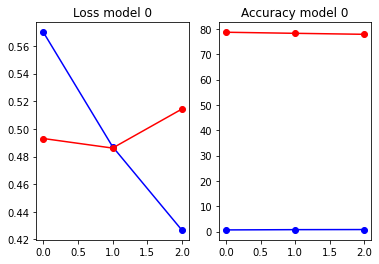

Some weights of the model checkpoint at prajjwal1/bert-small were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sequential(
  (0): Linear(in_features=512, out_features=64, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=64, out_features=32, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=32, out_features=2, bias=True)
)
Start training...

 Epoch  |  Batch  |  Train Loss  | F1 Train  |  Val Loss  |  Val Acc  |  F1 Val   |  Elapsed 
-----------------------------------------------------------------------------------------------
   1    |   20    |   0.652715   |   0.44    |     -      |     -     |     -     |   1.19   
   1    |   40    |   0.653742   |   0.42    |     -      |     -     |     -     |   1.16   
   1    |   60    |   0.645670   |   0.40    |     -      |     -     |     -     |   1.16   
   1    |   80    |   0.552394   |   0.51    |     -      |     -     |     -     |   1.16   
   1    |   100   |   0.595219   |   0.67    |     -      |     -     |     -     |   1.17   
   1    |   120   |   0.585675 

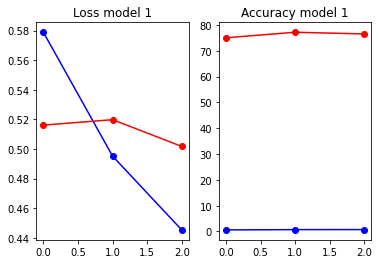

Some weights of the model checkpoint at prajjwal1/bert-small were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sequential(
  (0): Linear(in_features=512, out_features=64, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=64, out_features=32, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=32, out_features=2, bias=True)
)
Start training...

 Epoch  |  Batch  |  Train Loss  | F1 Train  |  Val Loss  |  Val Acc  |  F1 Val   |  Elapsed 
-----------------------------------------------------------------------------------------------
   1    |   20    |   0.663049   |   0.50    |     -      |     -     |     -     |   1.25   
   1    |   40    |   0.626724   |   0.51    |     -      |     -     |     -     |   1.21   
   1    |   60    |   0.622990   |   0.59    |     -      |     -     |     -     |   1.22   
   1    |   80    |   0.555465   |   0.71    |     -      |     -     |     -     |   1.22   
   1    |   100   |   0.525335   |   0.71    |     -      |     -     |     -     |   1.22   
   1    |   120   |   0.585598 

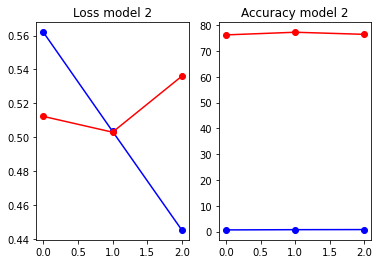

Some weights of the model checkpoint at prajjwal1/bert-small were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sequential(
  (0): Linear(in_features=512, out_features=64, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=64, out_features=32, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=32, out_features=2, bias=True)
)
Start training...

 Epoch  |  Batch  |  Train Loss  | F1 Train  |  Val Loss  |  Val Acc  |  F1 Val   |  Elapsed 
-----------------------------------------------------------------------------------------------
   1    |   20    |   0.652104   |   0.45    |     -      |     -     |     -     |   1.23   
   1    |   40    |   0.651444   |   0.43    |     -      |     -     |     -     |   1.20   
   1    |   60    |   0.623324   |   0.56    |     -      |     -     |     -     |   1.20   
   1    |   80    |   0.602198   |   0.62    |     -      |     -     |     -     |   1.20   
   1    |   100   |   0.554139   |   0.69    |     -      |     -     |     -     |   1.20   
   1    |   120   |   0.537824 

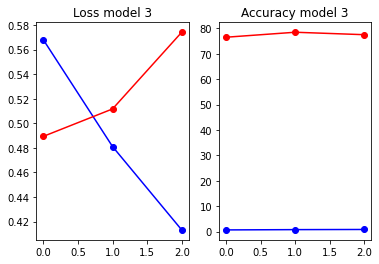

------RESULT------


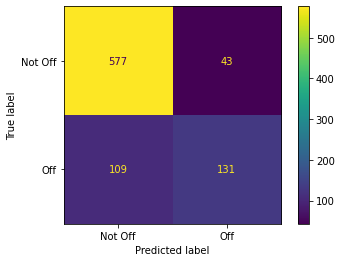

              precision    recall  f1-score   support

     Not Off     0.8411    0.9306    0.8836       620
         Off     0.7529    0.5458    0.6329       240

    accuracy                         0.8233       860
   macro avg     0.7970    0.7382    0.7582       860
weighted avg     0.8165    0.8233    0.8136       860

f1_score test tweets: 0.7582321651833603


In [ ]:
models, preds_ensemble = run_with_kfold(input_ids_train, attention_masks_train, test_dataloader, torch.tensor(label), label_test, H_PARAMETERS)

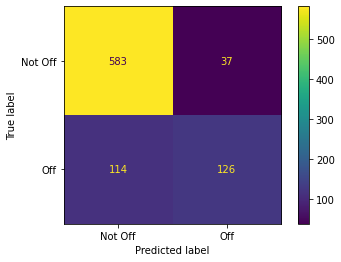

              precision    recall  f1-score   support

     Not Off     0.8364    0.9403    0.8853       620
         Off     0.7730    0.5250    0.6253       240

    accuracy                         0.8244       860
   macro avg     0.8047    0.7327    0.7553       860
weighted avg     0.8187    0.8244    0.8128       860

Bert model 0 tweets testset result => Loss: 0.4317060708999634 Accuracy: 82.44186046511628 F1 score: 75.53278279268433


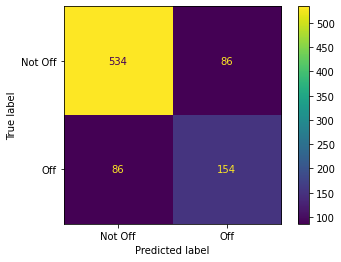

              precision    recall  f1-score   support

     Not Off     0.8613    0.8613    0.8613       620
         Off     0.6417    0.6417    0.6417       240

    accuracy                         0.8000       860
   macro avg     0.7515    0.7515    0.7515       860
weighted avg     0.8000    0.8000    0.8000       860

Bert model 1 tweets testset result => Loss: 0.44574496150016785 Accuracy: 80.0 F1 score: 75.14784946236558


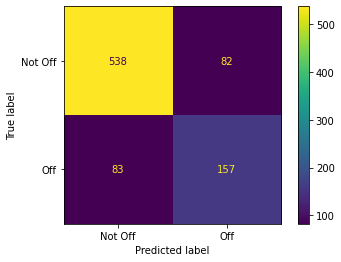

              precision    recall  f1-score   support

     Not Off     0.8663    0.8677    0.8670       620
         Off     0.6569    0.6542    0.6555       240

    accuracy                         0.8081       860
   macro avg     0.7616    0.7610    0.7613       860
weighted avg     0.8079    0.8081    0.8080       860

Bert model 2 tweets testset result => Loss: 0.4303770065307617 Accuracy: 80.81395348837209 F1 score: 76.12875332876881


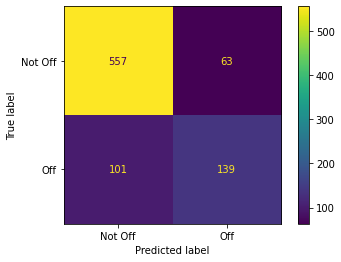

              precision    recall  f1-score   support

     Not Off     0.8465    0.8984    0.8717       620
         Off     0.6881    0.5792    0.6290       240

    accuracy                         0.8093       860
   macro avg     0.7673    0.7388    0.7503       860
weighted avg     0.8023    0.8093    0.8039       860

Bert model 3 tweets testset result => Loss: 0.49583733081817627 Accuracy: 80.93023255813954 F1 score: 75.03168837054504


In [ ]:
for i in range(len(models)):
  models[i].to(device)
  val_loss, val_accuracys, f1_value_tweets = evaluateFinal(models[i], test_dataloader, H_PARAMETERS['device'], H_PARAMETERS['loss'])
  models[i].to('cpu')
  print("Bert model {0} tweets testset result => Loss: {1} Accuracy: {2} F1 score: {3}".format(i, val_loss, val_accuracys, f1_value_tweets))

In [ ]:
showWrongPredictions(test_data, torch.tensor(label), preds_ensemble)

       id                   tweet
14  12588  user nigga ware da hit
       id                                   tweet
15  34263  stop kavanaugh liar like rest gop http
       id                                              tweet
38  46444  ariana asesina serious holy shit please fuck a...
       id                             tweet
39  60587  user hide ugly personality worst
       id       tweet
40  70569  bitch http
      id                                              tweet
0  15923  isq wheres server dump nike dec las fisa democ...
      id                                              tweet
1  27014  constitution day revere conservatives hat prog...
      id                                              tweet
3  13876  watch boomer get news still parole always make...
      id                                              tweet
6  96874  rap form art use express freely gv green light...
      id                                      tweet
7  65507  user get feel kiss behind humiliate 